In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
# Load the dataset
file_path = "US_Accidents_March23.csv"
data = pd.read_csv(file_path)

In [11]:
# Step 1: Data Cleaning and Processing
# Check for missing values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
print("Missing Values (%):\n", missing_percentage[missing_percentage > 0])

# Drop columns with high missing values (>50%)
high_missing_cols = missing_percentage[missing_percentage > 50].index
data = data.drop(columns=high_missing_cols)

# Fill remaining missing values with mean/median for numeric or mode for categorical
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        data[col] = data[col].fillna(data[col].median())

Missing Values (%):
 End_Lat                  44.029355
End_Lng                  44.029355
Description               0.000065
Street                    0.140637
City                      0.003274
Zipcode                   0.024779
Timezone                  0.101030
Airport_Code              0.292881
Weather_Timestamp         1.555666
Temperature(F)            2.120143
Wind_Chill(F)            25.865904
Humidity(%)               2.253301
Pressure(in)              1.820288
Visibility(mi)            2.291524
Wind_Direction            2.267043
Wind_Speed(mph)           7.391355
Precipitation(in)        28.512858
Weather_Condition         2.244438
Sunrise_Sunset            0.300787
Civil_Twilight            0.300787
Nautical_Twilight         0.300787
Astronomical_Twilight     0.300787
dtype: float64


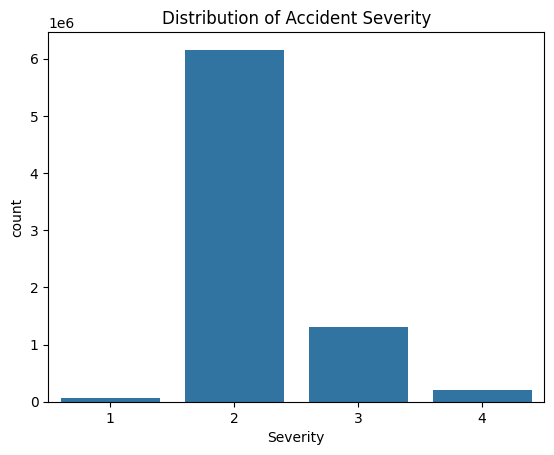

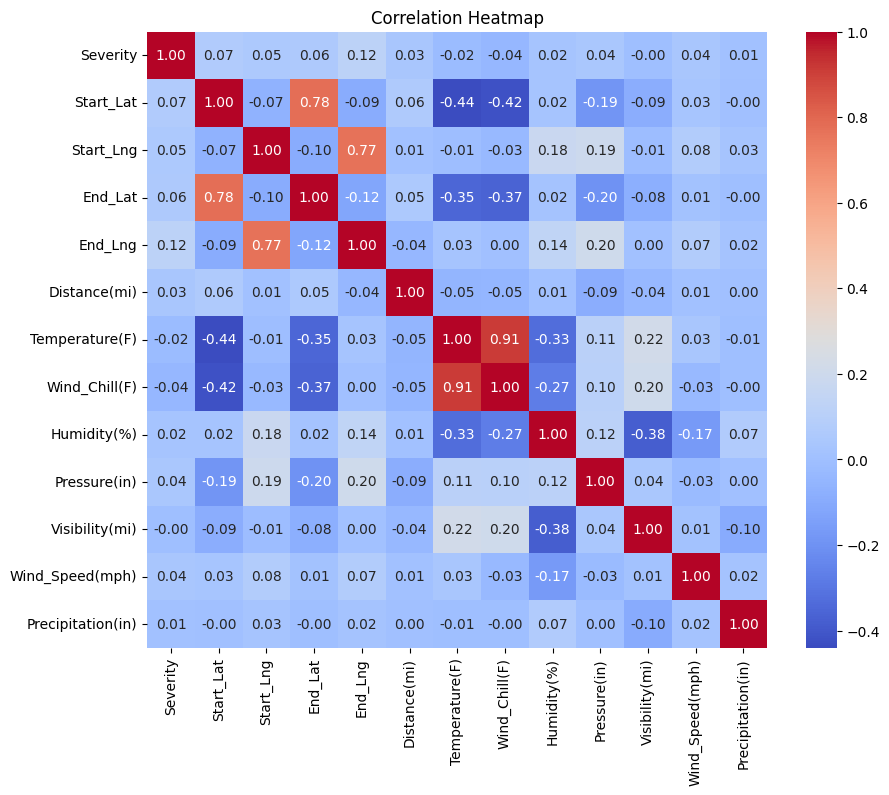

In [12]:
# Step 2: Exploratory Data Analysis
# Severity distribution
sns.countplot(x='Severity', data=data)
plt.title('Distribution of Accident Severity')
plt.show()

# Correlation heatmap for numerical features
numeric_features = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()


In [13]:
# Step 3: Feature Engineering
# Creating new feature: Accident Duration (in minutes)
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')
data['End_Time'] = pd.to_datetime(data['End_Time'], errors='coerce')
data['Duration'] = (data['End_Time'] - data['Start_Time']).dt.total_seconds() / 60

# Drop rows with invalid date conversions
data = data.dropna(subset=['Start_Time', 'End_Time'])

# Dropping non-essential columns for the model
columns_to_drop = ['ID', 'Start_Time', 'End_Time', 'Description', 'City', 'County', 'Street', 'Zipcode', 'Country']
data = data.drop(columns=columns_to_drop)

# Encoding categorical variables efficiently
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col], _ = pd.factorize(data[col])

In [15]:
# Step 4: Splitting Data
X = data.drop('Severity', axis=1)
y = data['Severity']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Step 5: Machine Learning Model
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Validation
y_validate_pred = model.predict(X_validate)
print("Validation Classification Report:\n", classification_report(y_validate, y_validate_pred))

Validation Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.66      0.72     10068
           2       0.91      0.95      0.93    814736
           3       0.79      0.71      0.75    195171
           4       0.62      0.38      0.48     27809

    accuracy                           0.89   1047784
   macro avg       0.77      0.68      0.72   1047784
weighted avg       0.88      0.89      0.88   1047784



Test Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.65      0.71      6729
           2       0.91      0.95      0.93    543334
           3       0.79      0.71      0.75    129891
           4       0.62      0.38      0.47     18569

    accuracy                           0.89    698523
   macro avg       0.77      0.67      0.71    698523
weighted avg       0.88      0.89      0.88    698523



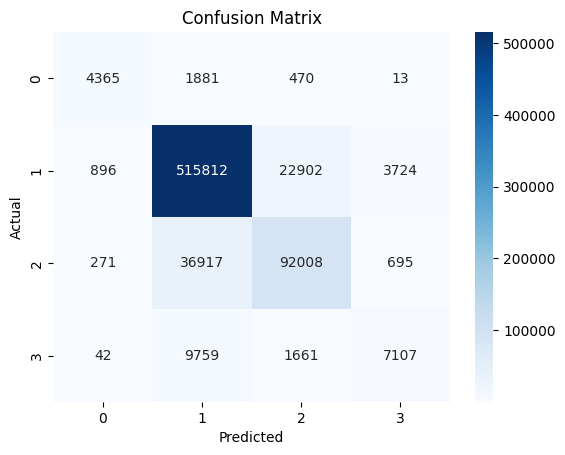

In [16]:
# Step 6: Testing
y_test_pred = model.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()